Anatomy of a Collapse: Pine Island Glacier Forensic Analysis
------------------------------------------------------------
Author: Jade Farrugia
Affiliation: Ocean Science & Monitoring Division, The Oceans Need Us

Date: 22/01/2026
License: MIT License

Description:
This script reproduces the remote sensing analysis for the 2020 PIG calving event.
It utilises Google Earth Engine (GEE) for:
1. Kinematic Velocity Mapping (Sentinel-1 SAR) using Offset Tracking (Joughin, 2002).
2. Structural Integrity Monitoring (Backscatter Analysis).
3. Environmental Forcing Analysis (ERA5 & MODIS LST).
4. Topographic Characterisation (CryoSat-2).

Requirements:
- earthengine-api
- geemap
- pandas
- matplotlib
- numpy

✅ Google Earth Engine Initialized successfully.
Starting Forensic Analysis for Pine Island Glacier...
Output Directory: C:\Users\jadef\Documents\Hobby_Projects\Antarctica_Remote_Sensing\02_Notebooks\outputs
⏳ Downloading CryoSat-2 Topography Raw Data...
⏳ Polishing Topography Map (Figure 2)...
   -> Figure 2 Saved: outputs\Figure_2_PIG_Topography_Final_Polished.png
⏳ generating Differential Velocity Field (Jan vs Feb Acceleration)...
   -> Found all 4 Sentinel-1 images. Calculating acceleration...
⏳ Polishing Velocity Map (Figure 3)...
   -> Figure 3 Saved: outputs\Figure_3_PIG_Kinematic_Collapse.png
⏳ Comparing 2019 Baseline vs 2020 Collapse (Figure 5)...


C:\Users\jadef\AppData\Local\Temp\ipykernel_26668\876345532.py:256: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_2019 = pd.Series(v_2019).interpolate().fillna(method='bfill')
C:\Users\jadef\AppData\Local\Temp\ipykernel_26668\876345532.py:257: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_2020 = pd.Series(v_2020).interpolate().fillna(method='bfill')


   -> Figure 5 Saved: outputs\Figure_5_Kinematic_Timeline.png
⏳ Extracting Radar Backscatter Time-Series (Figure 4)...
   -> Figure 4 Saved: outputs\Figure_4_Integrity_TimeSeries.png
⏳ Analyzing Atmospheric Forcing (Figure 6)...
   -> Figure 6 Saved: outputs\Figure_6_Temperature_Analysis.png
⏳ Analyzing Ocean Thermal Anomalies (Figure 7)...
   -> Figure 7 Saved: outputs\Figure_7_Ocean_Heat.png
✅ Analysis Complete. All figures generated in /outputs.


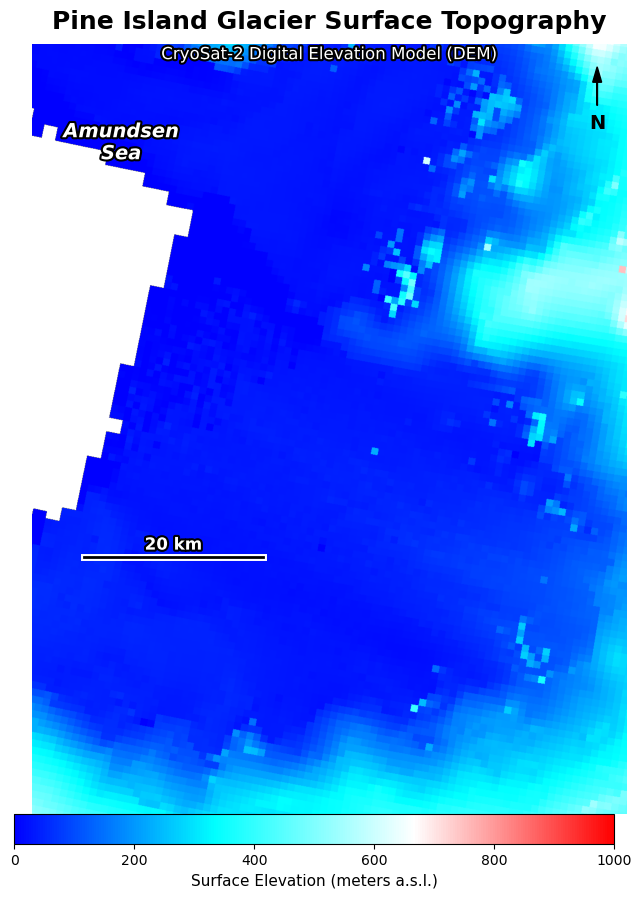

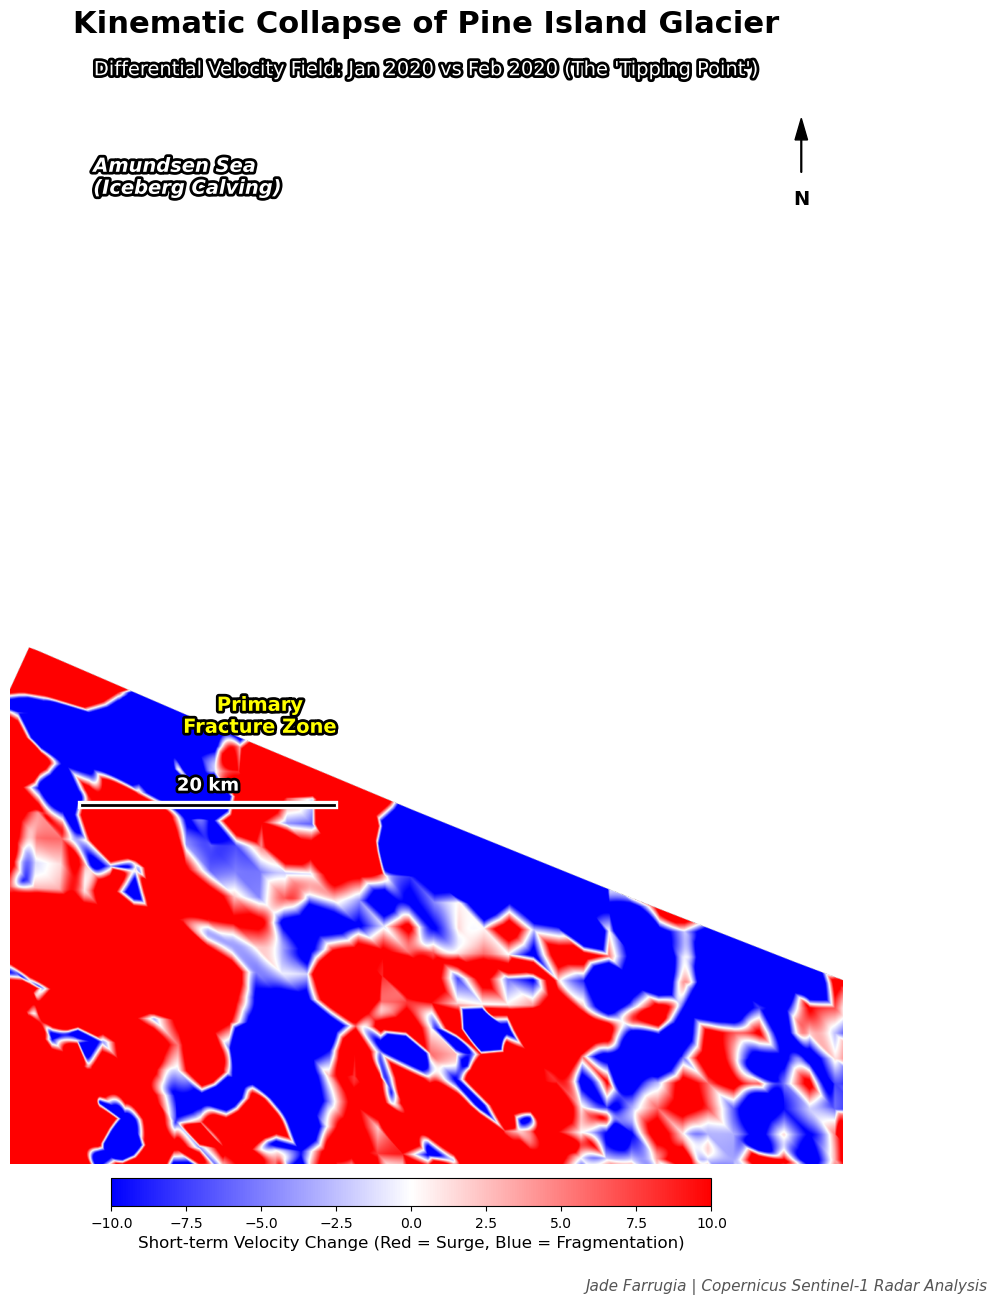

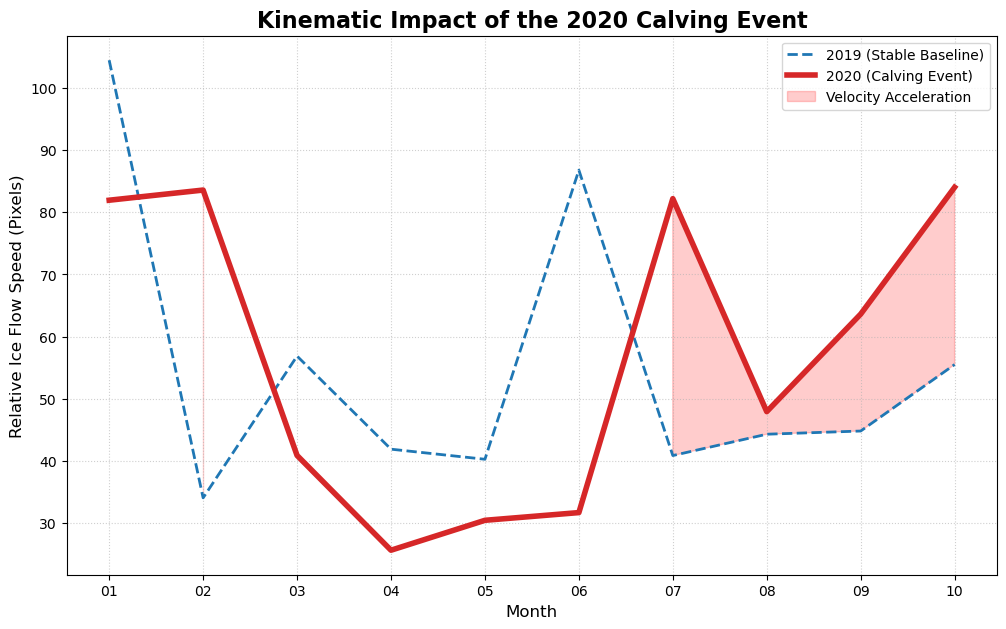

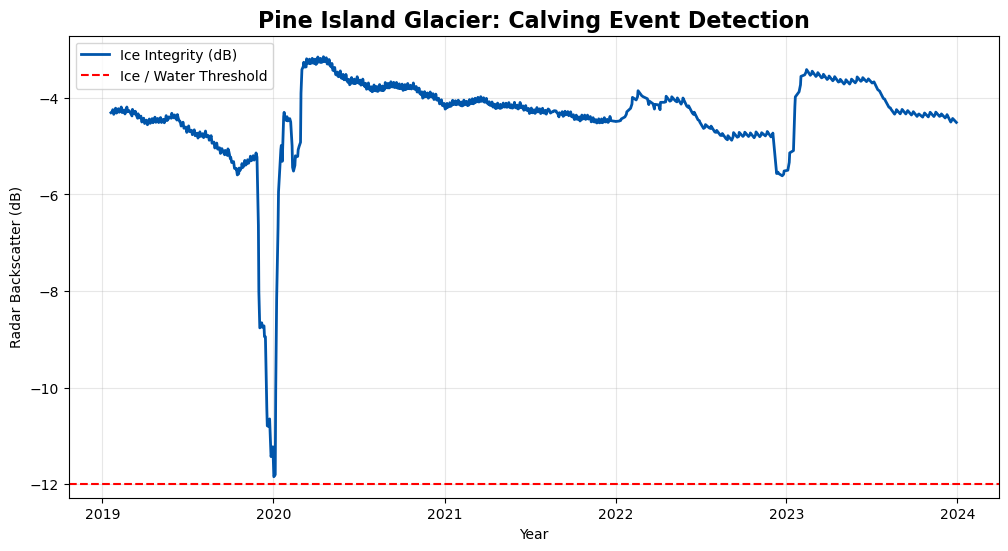

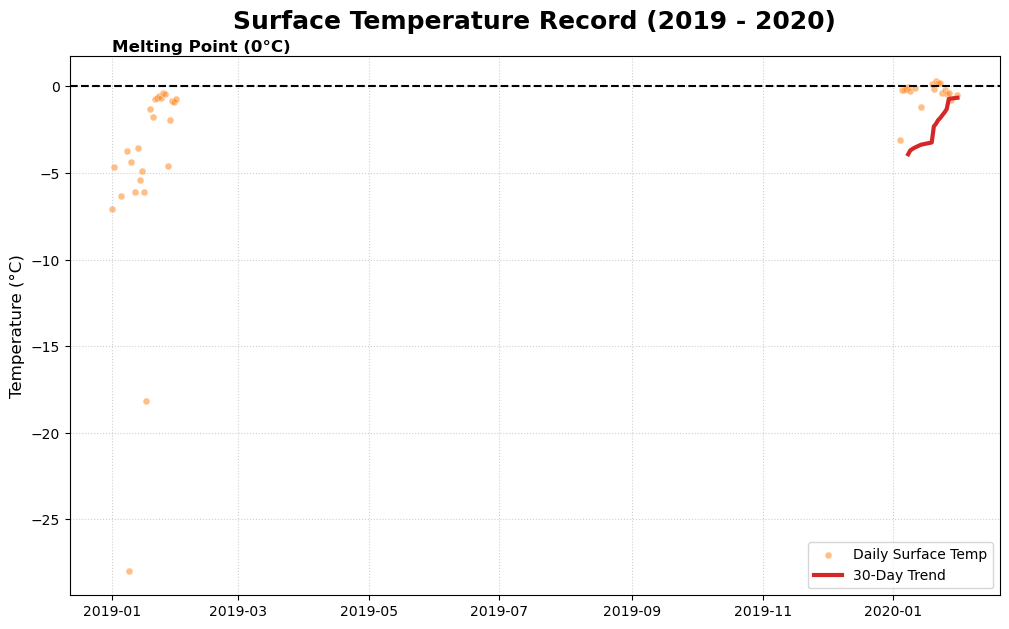

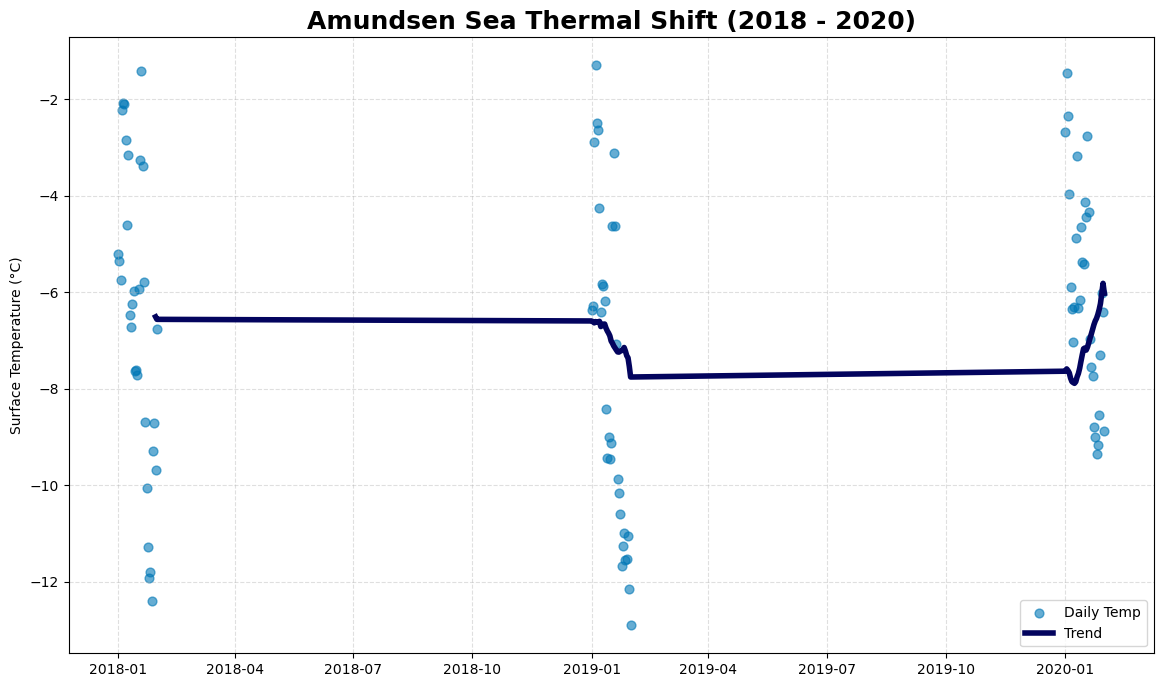

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
import os
import matplotlib.image as mpimg

# --- 1. INITIALISATION (Must run first) ---
PROJECT_ID = 'YOUR_GEE_PROJECT_ID_HERE'  # Replace with your GEE project ID

try:
    ee.Initialize(project=PROJECT_ID)
    print("✅ Google Earth Engine Initialized successfully.")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=PROJECT_ID)
    print("✅ Google Earth Engine Authenticated and Initialized.")

# --- 2. CONFIGURATION & GEOMETRIES ---
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ROI: Pine Island Glacier Trunk
PIG_GEOMETRY = ee.Geometry.Rectangle([-102.0, -75.5, -99.0, -74.5])
# Sample Point for Time-Series (Central Trunk)
SAMPLE_POINT = ee.Geometry.Point([-100.3, -75.35]).buffer(2000)
# Sample Area for Temperature/Velocity
SAMPLE_AREA_LARGE = ee.Geometry.Point([-101.5, -75.1]).buffer(5000)


# =============================================================================
# SECTION 1: TOPOGRAPHY (CRYOSAT-2) - FIGURE 2
# =============================================================================

def download_topography_raw():
    print("⏳ Downloading CryoSat-2 Topography Raw Data...")
    dataset = ee.Image("CPOM/CryoSat2/ANTARCTICA_DEM").select('elevation')
    
    vis_params = {
        'min': 0, 
        'max': 1000, 
        'palette': ['0000ff', '00ffff', 'ffffff', 'ff0000'] 
    }
    
    out_path = os.path.join(OUTPUT_DIR, "PIG_Topography_Raw.png")
    geemap.get_image_thumbnail(
        dataset, out_path, vis_params, dimensions=1500, region=PIG_GEOMETRY, format='png'
    )
    return out_path

def polish_topography_map(raw_img_path):
    print("⏳ Polishing Topography Map (Figure 2)...")
    if not os.path.exists(raw_img_path): return

    img = mpimg.imread(raw_img_path)
    
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
    ax.set_facecolor('#DDDDDD')
    ax.imshow(img)
    ax.axis('off')

    outline = [patheffects.withStroke(linewidth=3, foreground='black')]
    
    plt.text(0.5, 1.02, "Pine Island Glacier Surface Topography", transform=ax.transAxes, 
             color='black', ha='center', fontsize=18, fontweight='bold')
    plt.text(0.5, 0.98, "CryoSat-2 Digital Elevation Model (DEM)", transform=ax.transAxes, 
             color='white', ha='center', fontsize=12, path_effects=outline)
    plt.text(0.15, 0.85, "Amundsen\nSea", transform=ax.transAxes, 
             color='white', ha='center', fontsize=14, fontweight='bold', style='italic', path_effects=outline)

    # North Arrow
    ax.arrow(0.95, 0.92, 0, 0.05, transform=ax.transAxes, length_includes_head=True, 
             head_width=0.015, head_length=0.02, fc='black', ec='black')
    plt.text(0.95, 0.89, "N", transform=ax.transAxes, ha='center', fontsize=14, fontweight='bold')

    # Scale Bar
    scale_len_px = 350 
    bar_x, bar_y = 100, 1000 
    plt.plot([bar_x, bar_x + scale_len_px], [bar_y, bar_y], color='white', linewidth=5) 
    plt.plot([bar_x, bar_x + scale_len_px], [bar_y, bar_y], color='black', linewidth=2) 
    plt.text(bar_x + (scale_len_px/2), bar_y - 15, "20 km", color='white', ha='center', 
             fontsize=12, fontweight='bold', path_effects=outline)

    # Colourbar
    colors = ['#0000ff', '#00ffff', '#ffffff', '#ff0000']
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_glacier", colors)
    cax = fig.add_axes([0.25, 0.08, 0.5, 0.03]) 
    norm = mcolors.Normalize(vmin=0, vmax=1000)
    cb = mcolorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
    cb.set_label('Surface Elevation (meters a.s.l.)', fontsize=11)

    save_path = os.path.join(OUTPUT_DIR, "Figure_2_PIG_Topography_Final_Polished.png")
    plt.savefig(save_path, facecolor='white', dpi=300, bbox_inches='tight')
    print(f"   -> Figure 2 Saved: {save_path}")


# =============================================================================
# SECTION 2: KINEMATIC ANALYSIS (SENTINEL-1) - FIGURE 3 & 5
# =============================================================================

def generate_velocity_map_raw():
    """Generates the ACCELERATION map (Feb Speed minus Jan Speed)."""
    print("⏳ generating Differential Velocity Field (Jan vs Feb Acceleration)...")
    
    # Core displacement function
    def get_displacement(img1, img2):
        img1 = img1.focal_mean(radius=30, units='meters')
        img2 = img2.focal_mean(radius=30, units='meters')
        displacement = img1.displacement(
            referenceImage=img2,
            maxOffset=150.0, 
            patchWidth=100.0, 
            stiffness=2.0    
        )
        speed = displacement.select('dx').hypot(displacement.select('dy'))
        return speed

    # --- GET THE "CRISIS" DATA (4 Images for 2 Pairs) ---
    # Pre-Collapse Pair (January 2020)
    img_jan_1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(PIG_GEOMETRY).filterDate('2020-01-01', '2020-01-12').filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).first().select('HH')
    img_jan_2 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(PIG_GEOMETRY).filterDate('2020-01-13', '2020-01-25').filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).first().select('HH')

    # During-Collapse Pair (February 2020)
    img_feb_1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(PIG_GEOMETRY).filterDate('2020-02-01', '2020-02-12').filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).first().select('HH')
    img_feb_2 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(PIG_GEOMETRY).filterDate('2020-02-13', '2020-02-25').filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')).first().select('HH')

    # Verify we found images
    if img_jan_1.getInfo() and img_jan_2.getInfo() and img_feb_1.getInfo() and img_feb_2.getInfo():
        print("   -> Found all 4 Sentinel-1 images. Calculating acceleration...")
        
        # Calculate Speeds
        speed_jan = get_displacement(img_jan_1, img_jan_2)
        speed_feb = get_displacement(img_feb_1, img_feb_2)

        # Calculate Acceleration (Feb - Jan)
        diff_map = speed_feb.subtract(speed_jan)

        # Download
        out_path = os.path.join(OUTPUT_DIR, "PIG_Crisis_Velocity_Raw.png")
        vis_params = {'min': -10, 'max': 10, 'palette': ['blue', 'white', 'red']}
        
        geemap.get_image_thumbnail(diff_map, vis_params=vis_params, out_img=out_path, region=PIG_GEOMETRY, dimensions=1500, format='png')
        return out_path
    else:
        print("   ❌ Error: One or more S1 images missing for specified dates.")
        return None

def polish_velocity_map(img_path):
    """Polishes Figure 3 (Kinematic Collapse) using Dark Grey Ocean Style."""
    print("⏳ Polishing Velocity Map (Figure 3)...")
    
    if not os.path.exists(img_path):
        jpg_path = img_path.replace(".png", ".jpg")
        if os.path.exists(jpg_path):
            img_path = jpg_path
        else:
            print("   ❌ Raw image not found. Skipping polish.")
            return

    img_data = mpimg.imread(img_path)

    # --- SETUP CANVAS ---
    fig, ax = plt.subplots(figsize=(12, 14), facecolor='white') 
    
    # Dark grey background for open ocean
    ax.set_facecolor('#222222') 

    # Display Data
    ax.imshow(img_data)
    ax.axis('off')

    # Define Text Styles
    outline = [patheffects.withStroke(linewidth=4, foreground='black')]

    # --- TITLES ---
    plt.text(0.5, 1.05, "Kinematic Collapse of Pine Island Glacier", 
             transform=ax.transAxes, color='black', ha='center', fontsize=22, 
             fontweight='bold')

    plt.text(0.5, 1.01, "Differential Velocity Field: Jan 2020 vs Feb 2020 (The 'Tipping Point')", 
             transform=ax.transAxes, color='white', ha='center', fontsize=14,
             path_effects=outline)

    # --- ANNOTATIONS ---
    # Label the fracture zone
    plt.text(0.3, 0.4, "Primary\nFracture Zone", transform=ax.transAxes, 
             color='yellow', ha='center', fontsize=14, fontweight='bold',
             path_effects=outline)

    plt.text(0.1, 0.9, "Amundsen Sea\n(Iceberg Calving)", transform=ax.transAxes, 
             color='white', ha='left', fontsize=14, fontweight='bold', style='italic',
             path_effects=outline)

    # --- PROFESSIONAL ELEMENTS ---
    # North Arrow
    ax.arrow(0.95, 0.92, 0, 0.05, transform=ax.transAxes, 
             length_includes_head=True, head_width=0.015, head_length=0.02, 
             fc='black', ec='black')
    plt.text(0.95, 0.89, "N", transform=ax.transAxes, ha='center', fontsize=14, fontweight='bold')

    # Scale Bar (20km)
    scale_len_px = 350
    bar_x, bar_y = 100, 1000 
    plt.plot([bar_x, bar_x + scale_len_px], [bar_y, bar_y], color='white', linewidth=6) 
    plt.plot([bar_x, bar_x + scale_len_px], [bar_y, bar_y], color='black', linewidth=2) 
    plt.text(bar_x + (scale_len_px/2), bar_y - 20, "20 km", 
             color='white', ha='center', fontsize=13, fontweight='bold', path_effects=outline)

    # --- COLOURBAR ---
    colors = ['blue', 'white', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("crisis_cmap", colors)
    cax = fig.add_axes([0.25, 0.08, 0.5, 0.02]) 
    norm = mcolors.Normalize(vmin=-10, vmax=10)
    cb = mcolorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
    cb.set_label('Short-term Velocity Change (Red = Surge, Blue = Fragmentation)', fontsize=12)

    # --- SIGNATURE ---
    plt.text(0.98, 0.02, "Jade Farrugia | Copernicus Sentinel-1 Radar Analysis", 
             transform=fig.transFigure, color='#555555', ha='right', fontsize=11, style='italic')

    # --- SAVE ---
    out_png = os.path.join(OUTPUT_DIR, "Figure_3_PIG_Kinematic_Collapse.png")
    plt.savefig(out_png, facecolor='white', dpi=300, bbox_inches='tight')
    print(f"   -> Figure 3 Saved: {out_png}")

def analyze_kinematic_timeline():
    """Generates Figure 5: The Velocity Surge Timeline."""
    print("⏳ Comparing 2019 Baseline vs 2020 Collapse (Figure 5)...")
    
    def calc_speed_for_date(start, end):
        s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterBounds(SAMPLE_AREA_LARGE) \
            .filterDate(start, end) \
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
        if s1.size().getInfo() < 2: return None
        img_list = s1.toList(5)
        img1 = ee.Image(img_list.get(0)).select('HH')
        img2 = ee.Image(img_list.get(1)).select('HH')
        disp = img1.displacement(referenceImage=img2, maxOffset=150.0, patchWidth=100.0, stiffness=2.0)
        speed = disp.select('dx').hypot(disp.select('dy')).rename('velocity')
        stats = speed.reduceRegion(ee.Reducer.mean(), SAMPLE_AREA_LARGE, 100).get('velocity')
        return stats.getInfo()

    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
    v_2019, v_2020 = [], []

    for m in months:
        v_2019.append(calc_speed_for_date(f'2019-{m}-01', f'2019-{m}-28'))
        v_2020.append(calc_speed_for_date(f'2020-{m}-01', f'2020-{m}-28'))

    s_2019 = pd.Series(v_2019).interpolate().fillna(method='bfill')
    s_2020 = pd.Series(v_2020).interpolate().fillna(method='bfill')

    plt.figure(figsize=(12, 7), facecolor='white')
    plt.plot(months, s_2019, label='2019 (Stable Baseline)', color='#1f77b4', linestyle='--', linewidth=2)
    plt.plot(months, s_2020, label='2020 (Calving Event)', color='#d62728', linewidth=4)
    plt.fill_between(months, s_2019, s_2020, where=(s_2020 > s_2019), color='red', alpha=0.2, label='Velocity Acceleration')

    plt.title('Kinematic Impact of the 2020 Calving Event', fontsize=16, fontweight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Relative Ice Flow Speed (Pixels)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)

    save_path = os.path.join(OUTPUT_DIR, "Figure_5_Kinematic_Timeline.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   -> Figure 5 Saved: {save_path}")


# =============================================================================
# SECTION 3: STRUCTURAL INTEGRITY - FIGURE 4
# =============================================================================

def analyze_structural_integrity():
    """Generates Figure 4: Backscatter Time Series."""
    print("⏳ Extracting Radar Backscatter Time-Series (Figure 4)...")
    
    def get_radar_val(image):
        mean_val = image.reduceRegion(ee.Reducer.mean(), SAMPLE_POINT, 30).get('HH')
        return image.set('radar_brightness', mean_val).set('date', image.date().format('YYYY-MM-dd'))

    collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(SAMPLE_POINT) \
        .filterDate('2019-01-01', '2024-01-01') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH')) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .select('HH') \
        .map(get_radar_val)

    data = collection.filter(ee.Filter.notNull(['radar_brightness'])).reduceColumns(
        ee.Reducer.toList(2), ['date', 'radar_brightness']
    ).get('list').getInfo()

    df = pd.DataFrame(data, columns=['Date', 'dB'])
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date']).sort_values('Date')
    df['Smoothed'] = df['dB'].rolling(window=10).mean()
    
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(df['Date'], df['Smoothed'], color='#0055AA', linewidth=2, label='Ice Integrity (dB)')
    plt.axhline(y=-12, color='red', linestyle='--', label='Ice / Water Threshold')
    plt.title("Pine Island Glacier: Calving Event Detection", fontsize=16, fontweight='bold')
    plt.ylabel("Radar Backscatter (dB)")
    plt.xlabel("Year")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    save_path = os.path.join(OUTPUT_DIR, "Figure_4_Integrity_TimeSeries.png")
    plt.savefig(save_path, dpi=300)
    print(f"   -> Figure 4 Saved: {save_path}")


# =============================================================================
# SECTION 4: ENVIRONMENTAL FORCING - FIGURE 6 & 7
# =============================================================================

def analyze_atmospheric_forcing():
    """Generates Figure 6: MODIS LST Analysis."""
    print("⏳ Analyzing Atmospheric Forcing (Figure 6)...")
    
    lst_collection = ee.ImageCollection("MODIS/061/MOD11A1") \
        .filterDate('2019-01-01', '2020-12-31') \
        .select('LST_Day_1km')

    def get_temp_data(img):
        temp_c = img.multiply(0.02).subtract(273.15)
        stats = temp_c.reduceRegion(ee.Reducer.mean(), SAMPLE_AREA_LARGE, 1000)
        return ee.Feature(None, {'temp': stats.get('LST_Day_1km'), 'date': img.date().format('YYYY-MM-DD')})

    temp_features = lst_collection.map(get_temp_data).filter(ee.Filter.notNull(['temp']))
    temp_list = temp_features.aggregate_array('temp').getInfo()
    date_list = temp_features.aggregate_array('date').getInfo()

    df_temp = pd.DataFrame({'Date': pd.to_datetime(date_list, errors='coerce'), 'Temp': temp_list})
    df_temp = df_temp.dropna(subset=['Date'])

    plt.figure(figsize=(12, 7), facecolor='white')
    plt.scatter(df_temp['Date'], df_temp['Temp'], color='#ff7f0e', s=25, alpha=0.5, edgecolors='white', linewidth=0.5, label='Daily Surface Temp')
    plt.plot(df_temp['Date'], df_temp['Temp'].rolling(30).mean(), color='#d62728', linewidth=3, label='30-Day Trend')
    plt.axhline(0, color='black', linestyle='--', linewidth=1.5)
    plt.text(df_temp['Date'].min(), 2, "Melting Point (0°C)", fontsize=12, fontweight='bold', color='black', ha='left')
    plt.title('Surface Temperature Record (2019 - 2020)', fontsize=18, fontweight='bold', pad=20)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(loc='lower right')

    save_path = os.path.join(OUTPUT_DIR, "Figure_6_Temperature_Analysis.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   -> Figure 6 Saved: {save_path}")

def analyze_ocean_forcing():
    """Generates Figure 7: ERA5 Ocean Heat Analysis."""
    print("⏳ Analyzing Ocean Thermal Anomalies (Figure 7)...")
    
    ocean_roi = ee.Geometry.Point([-102.5, -74.8]).buffer(50000)
    collection = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR") \
        .filterDate('2018-01-01', '2021-01-01').select('skin_temperature')

    def get_stats(img):
        temp_c = img.subtract(273.15)
        val = temp_c.reduceRegion(ee.Reducer.mean(), ocean_roi, 25000).get('skin_temperature')
        return ee.Feature(None, {'temp': val, 'date': img.date().format('YYYY-MM-DD')})

    stats = collection.map(get_stats).filter(ee.Filter.notNull(['temp']))
    data = stats.reduceColumns(ee.Reducer.toList(2), ['date', 'temp']).get('list').getInfo()
    
    df = pd.DataFrame(data, columns=['Date', 'Temp'])
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date']).sort_values('Date')

    plt.figure(figsize=(14, 8), facecolor='white')
    plt.scatter(df['Date'], df['Temp'], color='#0077b6', s=40, alpha=0.6, label='Daily Temp')
    plt.plot(df['Date'], df['Temp'].rolling(30).mean(), color='#03045e', linewidth=4, label='Trend')
    plt.title('Amundsen Sea Thermal Shift (2018 - 2020)', fontsize=18, fontweight='bold')
    plt.ylabel('Surface Temperature (°C)')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    
    save_path = os.path.join(OUTPUT_DIR, "Figure_7_Ocean_Heat.png")
    plt.savefig(save_path, dpi=300)
    print(f"   -> Figure 7 Saved: {save_path}")


# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print(f"Starting Forensic Analysis for Pine Island Glacier...")
    print(f"Output Directory: {os.path.abspath(OUTPUT_DIR)}")
    
    # 1. Topography
    raw_topo_path = download_topography_raw()
    polish_topography_map(raw_topo_path)

    # 2. Kinematics (Figure 3 & 5)
    # Generates PIG_Crisis_Velocity_Raw.png
    raw_vel_path = generate_velocity_map_raw()
    # Polishes it with your exact Dark Grey styling
    polish_velocity_map(raw_vel_path)
    
    # Generates Timeline (Fig 5)
    analyze_kinematic_timeline()

    # 3. Structural (Figure 4)
    analyze_structural_integrity()

    # 4. Forcing (Figure 6 & 7)
    analyze_atmospheric_forcing()
    analyze_ocean_forcing()
    
    print("✅ Analysis Complete. All figures generated in /outputs.")